# 1. Blocker Fraud Company
 <font size="2"> Dados e problema negócio hipotéticos</font>
 
A Blocker Fraud Company é uma empresa especializada na detecção de fraudes em transações financeiras feitas atravś de dispositivos móveis.

O modelo de negócio da empresa é do tipo Serviço com a monetização feita por performance do serviço prestado, ou seja, o usuário paga uma taxa fixa sobre o sucesso da detecção de fraude das transações.

## 1.1. Estratégia de expansão

A Blocker Fraud Company está em fase de expansão no Brasil e para adquirir clientes mais rapidamente, ela adotou uma estratégia muito agressiva. A estratégia funciona da seguinte forma:

1. A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.
2. A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.
3. A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.

Com essa estratégia agressiva a empresa assume os riscos em falhar na detecção de fraude e é remunerada na detecção assertiva das fraudes.

## 1.2. Objetivo

Criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

### 1.2.1. Entregáveis

Modelo em produção no qual seu acesso será feito via API, ou seja, os clientes enviarão suas transações via API para que o seu modelo as classifique como fraudulentas ou legítimas.

Além disso, você precisará entregar um relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu. No seu relatório deve conter as respostas para as seguintes perguntas:

1. Qual a Precisão e Acurácia do modelo?
2. Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
3. Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
4. Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
5. Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?


# 2. Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

#display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn import model_selection
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
from sklearn import pipeline
from sklearn import preprocessing

from feature_engine import wrappers 
from feature_engine import selection
from feature_engine import imputation
from feature_engine import encoding
from feature_engine import discretisation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve, classification_report

## 2.1. Utils functions

In [2]:
def performance(model, x_train, y_train):
    
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    scores = model_selection.cross_validate(model, x_train, y_train, cv=5, scoring=scoring)

    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def precision_recall_curve_graph(model, x_train, y_train):
    probs = model.predict_proba(x_train)
    positive_probs = probs[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_train, positive_probs)
    no_skill = len(y_train[y_train==1]) / len(y_train)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Model')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.legend()

    plt.show()
    
def roc_curve_graph(model, x_train, y_train):
    ns_probs = [0 for _ in range(len(y_train))]

    probs = model.predict_proba(x_train)
    positive_probs = probs[:, 1]
    
    
    ns_auc = roc_auc_score(y_train, ns_probs)
    roc_auc = roc_auc_score(y_train, positive_probs)

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (roc_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
    model_fpr, model_tpr, _ = roc_curve(y_train, positive_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(model_fpr, model_tpr, marker='.', label='Model')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()

    plt.show()
    
def create_classification_report(model, x_train, y_train):
    y_pred = model.predict(x_train)
    return print(classification_report(y_train, y_pred))

# 3. Data

## 3.1. Load dataset

In [3]:
df = pd.read_parquet('../data/raw/df_applied_features.parquet.gzip') 

In [4]:
df_test = pd.read_parquet('../data/raw/df_applied_features_test.parquet.gzip') 

# 4. Model

## 4.1. Define feature and target

In [5]:
features = df.drop('isFraud', axis=1).columns.tolist()
target = 'isFraud'

## 4.2. Split data into train and valid

In [6]:
X = df[features]
y = df[target].values

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,
                                                                      y,
                                                                      random_state=42,
                                                                      test_size=0.3,
                                                                      stratify=y)

In [7]:
cols_to_include = ['isFlaggedFraud', 'is_high_amount', 'is_M_customer', 
                   'is_new_balance_orig_zero', 'is_orig_old_balance_greater_new',
                   'is_new_balance_dest_zero', 'is_dest_old_balance_greater_new']

columns_drop = ['nameOrig', 'nameDest']

for col in cols_to_include:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    
X_train.drop(columns_drop, axis=1, inplace=True)
X_valid.drop(columns_drop, axis=1, inplace=True)

In [8]:
X_test = df_test[features].copy()
y_test = df_test[target]


for col in cols_to_include:
    X_test[col] = X_test[col].astype('category')
    
X_test.drop(columns_drop, axis=1, inplace=True)

## 4.4. Load pipeline

In [9]:
pipe = joblib.load('../models/model_cicle_1.pkl')

# 5. Feature selection

## 5.1. Feature selection by random forest importances

In [10]:
important_features = pd.Series(data=pipe.named_steps['model'].feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)

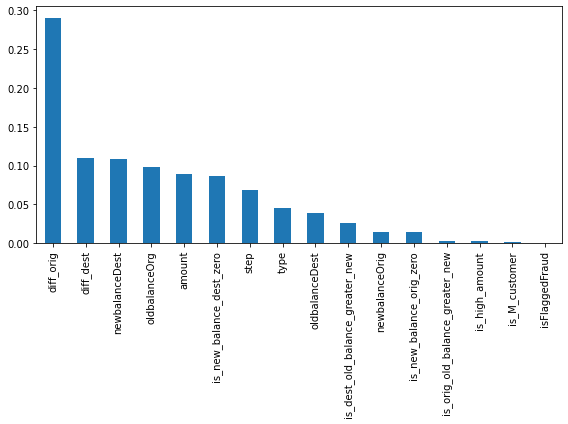

In [11]:
plt.subplots(figsize=(8,6))
important_features.plot(kind='bar')
plt.tight_layout()

In [15]:
selected_features = ['diff_orig', 'diff_dest', 'newbalanceDest', 'oldbalanceOrg',
                    'amount', 'is_new_balance_dest_zero', 'step', 'type', 'oldbalanceDest']

cat_features = ['is_new_balance_dest_zero',
                'type']
num_features = ['diff_orig', 'diff_dest', 'newbalanceDest', 'oldbalanceOrg',
                    'amount', 'step', 'oldbalanceDest']

rf_clf = ensemble.RandomForestClassifier(n_jobs=-1,
                                         random_state=42)
cat_enc = encoding.CountFrequencyEncoder(variables=cat_features)
rare_enc = encoding.RareLabelEncoder(variables=['type'])
numerical_enc = wrappers.SklearnTransformerWrapper(transformer = preprocessing.StandardScaler(),
                                                   variables = num_features)

pipe_rf_ft_importance = pipeline.Pipeline(steps = [("enconding_rare", rare_enc),
                                  ("enconding_cat", cat_enc),
                                  ("enconding_num", numerical_enc),
                                  ("model", rf_clf)])

pipe_rf_ft_importance.fit(X_train[selected_features], y_train)

Pipeline(steps=[('enconding_rare', RareLabelEncoder(variables=['type'])),
                ('enconding_cat',
                 CountFrequencyEncoder(variables=['is_new_balance_dest_zero',
                                                  'type'])),
                ('enconding_num',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['diff_orig', 'diff_dest',
                                                      'newbalanceDest',
                                                      'oldbalanceOrg', 'amount',
                                                      'step',
                                                      'oldbalanceDest'])),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [16]:
performance(pipe_rf_ft_importance, X_train[selected_features], y_train)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.99968,0.98262,0.76314,0.85902,0.88156,0.86578


In [17]:
performance(pipe_rf_ft_importance, X_test[selected_features], y_test)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.99956,0.95545,0.71503,0.81594,0.85749,0.82532


# 6. Conclusion

Os testes acima de selecionar as variáveis mais úteis para o modelo não tiveram êxito em conseguir um recall maior do que utilizando todas as variáveis (notebook 7 passo 5.3), portanto iremos prosseguir utilizando todas as variáveis na próximas etapas, não sendo necessário atuação, nesse primeiro ciclo.